In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize
import numpy as np
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

BATCH_SIZE=32
EPOCHS=20
EPSISON=0.05

# Load and preprocess CIFAR-10 data (subset)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)

# Use a subset to reduce compute
x_train, y_train = x_train[:5000], y_train[:5000]
x_val, y_val = x_test[:1000], y_test[:1000]

# Resize images for ResNet50 (224x224)
x_train = resize(x_train, [224, 224])
x_val = resize(x_val, [224, 224])

# Data generators
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

# Build ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-30:]:
    layer.trainable = True  # Unfreeze some base layers to reduce compute
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Compile and train
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, verbose=1, callbacks=callbacks)

# Save the model
model.save('resnet50_cifar10.h5')

# Evaluate on clean validation set
val_generator.reset()
clean_loss, clean_acc = model.evaluate(val_generator, verbose=1)
print(f"Clean Data - Loss: {clean_loss:.4f}, Accuracy: {clean_acc:.4f}")

2025-04-20 14:42:57.624793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745160177.834675   75394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745160177.898453   75394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 14:42:58.458286: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1745160186.296259   75394 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20

Epoch 1/20


I0000 00:00:1745160201.353719   75472 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1745160204.046860   75474 service.cc:148] XLA service 0x7f980d447270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745160204.046906   75474 service.cc:156]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2025-04-20 14:43:24.073643: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745160204.216912   75474 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 [==============================] - 50s 150ms/step - loss: 1.8240 - accuracy: 0.3836 - val_loss: 4.9455 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 2/20
157/157 [==============================] - 21s 132ms/step - loss: 0.8867 - accuracy: 0.7166 - val_loss: 11.0344 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 3/20
157/157 [==============================] - 21s 132ms/step - loss: 0.5021 - accuracy: 0.8526 - val_loss: 7.5326 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 4/20
157/157 [==============================] - 21s 131ms/step - loss: 0.3094 - accuracy: 0.9086 - val_loss: 5.0837 - val_accuracy: 0.1000 - lr: 1.0000e-05
Epoch 5/20
157/157 [==============================] - 21s 132ms/step - loss: 0.2064 - accuracy: 0.9466 - val_loss: 3.2098 - val_accuracy: 0.1210 - lr: 1.0000e-06
Epoch 6/20
157/157 [==============================] - 21s 132ms/step - loss: 0.1862 - accuracy: 0.9574 - val_loss: 1.2851 - val_accuracy: 0.5410 - lr: 1.0000e-06
Epoch 7/20
157/157 [==================

/opt/tensorflow/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 1s 38ms/step - loss: 0.4235 - accuracy: 0.8690
Clean Data - Loss: 0.4235, Accuracy: 0.8690


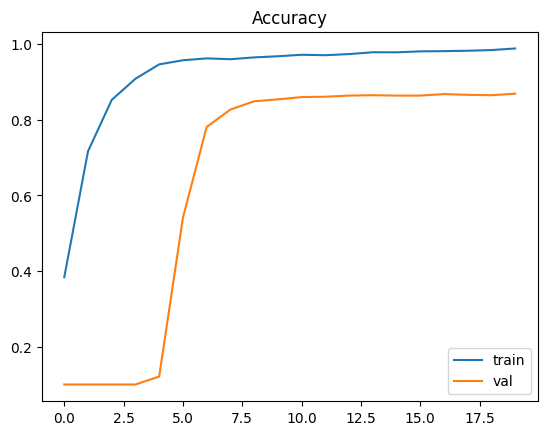

In [2]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

In [3]:
import tensorflow as tf
import numpy as np

# Load the trained model
model = tf.keras.models.load_model('resnet50_cifar10.h5')

# FGSM attack implementation
def fgsm_attack(model, images, labels, epsilon):
    images = tf.cast(images, tf.float32)
    labels = tf.cast(labels, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)
    adv_images = images + epsilon * signed_grad
    adv_images = tf.clip_by_value(adv_images, 0, 1)
    return adv_images

# Evaluate on adversarial examples
def evaluate_adversarial(model, generator, epsilon):
    total_loss, total_acc = 0, 0
    num_batches = 0
    generator.reset()
    for images, labels in generator:
        adv_images = fgsm_attack(model, images, labels, epsilon)
        loss, acc = model.evaluate(adv_images, labels, verbose=1)
        total_loss += loss
        total_acc += acc
        num_batches += 1
        if num_batches >= 10:  # Limit to 10 batches
            break
    avg_loss = total_loss / num_batches
    avg_acc = total_acc / num_batches
    return avg_loss, avg_acc

# Evaluate FGSM with epsilon=0.05
epsilon = 0.05
fgsm_loss, fgsm_acc = evaluate_adversarial(model, val_generator, epsilon)
print(f"FGSM Attack (epsilon={epsilon}) - Loss: {fgsm_loss:.4f}, Accuracy: {fgsm_acc:.4f}")

# Calculate fooling rate
clean_loss, clean_acc = model.evaluate(val_generator, verbose=1)
fooling_rate = (clean_acc - fgsm_acc) / clean_acc * 100
print(f"Fooling Rate: {fooling_rate:.2f}%")

1/1 [==============================] - 0s 56ms/step - loss: 6.4568 - accuracy: 0.0625
FGSM Attack (epsilon=0.05) - Loss: 6.2947, Accuracy: 0.1125
32/32 [==============================] - 2s 39ms/step - loss: 0.4235 - accuracy: 0.8690
Fooling Rate: 87.05%


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Build a new ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)
adv_model = Model(inputs=base_model.input, outputs=predictions)

# Compile
adv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

# Custom training loop with fit
def adversarial_training(model, train_generator, val_generator, epochs=10, epsilon=EPSISON, callbacks=None):
    for epoch in range(epochs):
        print(f"Adversarial Training Epoch {epoch+1}/{epochs}")
        train_generator.reset()
        
        # Create a mixed dataset for this epoch
        images_list, labels_list = [], []
        adv_images_list = []
        for images, labels in train_generator:
            images_list.append(images)
            labels_list.append(labels)
            adv_images = fgsm_attack(model, images, labels, epsilon)
            adv_images_list.append(adv_images)
            if len(images_list) >= 100:
                break
        
        # Concatenate clean and adversarial data
        images_all = np.concatenate(images_list + adv_images_list, axis=0)
        labels_all = np.concatenate(labels_list + labels_list, axis=0)
        
        # Create a temporary generator for fit using NumpyArrayIterator
        mixed_generator = tf.keras.preprocessing.image.NumpyArrayIterator(
            images_all, labels_all, image_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(),
            batch_size=train_generator.batch_size, shuffle=True
        )
        
        # Train for one epoch using fit
        history = model.fit(mixed_generator, epochs=1, validation_data=val_generator, callbacks=callbacks, verbose=1)

# Train with early stopping
adversarial_training(adv_model, train_generator, val_generator, epochs=10, epsilon=EPSISON, callbacks=[early_stopping])

# Save the adversarially trained model
adv_model.save('resnet50_cifar10_adv_mixed.h5')

Adversarial Training Epoch 1/10
200/200 [==============================] - 48s 135ms/step - loss: 0.6762 - accuracy: 0.7758 - val_loss: 2.7873 - val_accuracy: 0.1060
Restoring model weights from the end of the best epoch: 1.
Adversarial Training Epoch 2/10
200/200 [==============================] - 26s 132ms/step - loss: 0.3598 - accuracy: 0.8819 - val_loss: 2.8424 - val_accuracy: 0.0940
Restoring model weights from the end of the best epoch: 1.
Adversarial Training Epoch 3/10
200/200 [==============================] - 26s 131ms/step - loss: 0.2518 - accuracy: 0.9150 - val_loss: 3.0181 - val_accuracy: 0.1700
Restoring model weights from the end of the best epoch: 1.
Adversarial Training Epoch 4/10
200/200 [==============================] - 26s 131ms/step - loss: 0.1844 - accuracy: 0.9398 - val_loss: 1.8786 - val_accuracy: 0.4090
Restoring model weights from the end of the best epoch: 1.
Adversarial Training Epoch 5/10
200/200 [==============================] - 26s 131ms/step - loss: 0.

/opt/tensorflow/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# Load both models
natural_model = tf.keras.models.load_model('resnet50_cifar10.h5')
adv_model = tf.keras.models.load_model('resnet50_cifar10_adv.h5')

# Evaluate natural model
val_generator.reset()
natural_clean_loss, natural_clean_acc = natural_model.evaluate(val_generator, verbose=1)
natural_fgsm_loss, natural_fgsm_acc = evaluate_adversarial(natural_model, val_generator, epsilon=EPSISON)

# Evaluate adversarially trained model
val_generator.reset()
adv_clean_loss, adv_clean_acc = adv_model.evaluate(val_generator, verbose=1)
adv_fgsm_loss, adv_fgsm_acc = evaluate_adversarial(adv_model, val_generator, epsilon=0.05)
# Calculate fooling rate for both models
natural_fooling_rate = (natural_clean_acc - natural_fgsm_acc) / natural_clean_acc * 100
adv_fooling_rate = (adv_clean_acc - adv_fgsm_acc) / adv_clean_acc * 100
print(f"Natural Model Fooling Rate: {natural_fooling_rate:.2f}%")
print(f"Adversarially Trained Model Fooling Rate: {adv_fooling_rate:.2f}%")

# Compare
print("Natural Model:")
print(f"Clean Data - Loss: {natural_clean_loss:.4f}, Accuracy: {natural_clean_acc:.4f}")
print(f"FGSM Attack (epsilon=0.05) - Loss: {natural_fgsm_loss:.4f}, Accuracy: {natural_fgsm_acc:.4f}")
print("\nAdversarially Trained Model:")
print(f"Clean Data - Loss: {adv_clean_loss:.4f}, Accuracy: {adv_clean_acc:.4f}")
print(f"FGSM Attack (epsilon=0.05) - Loss: {adv_fgsm_loss:.4f}, Accuracy: {adv_fgsm_acc:.4f}")

1/1 [==============================] - 0s 64ms/step - loss: 0.4049 - accuracy: 0.8750
Natural Model Fooling Rate: 89.57%
Adversarially Trained Model Fooling Rate: -717.09%
Natural Model:
Clean Data - Loss: 0.4235, Accuracy: 0.8690
FGSM Attack (epsilon=0.05) - Loss: 6.6825, Accuracy: 0.0906

Adversarially Trained Model:
Clean Data - Loss: 7.0002, Accuracy: 0.1090
FGSM Attack (epsilon=0.05) - Loss: 0.3114, Accuracy: 0.8906


1/1 [==============================] - 0s 63ms/step - loss: 4.4721 - accuracy: 0.0625


1/1 [==============================] - 0s 62ms/step - loss: 3.9463 - accuracy: 0.0312
Epsilon: 0.01, Accuracy: 0.0625
1/1 [==============================] - 0s 62ms/step - loss: 0.3479 - accuracy: 0.8750
Epsilon: 0.05, Accuracy: 0.9062
1/1 [==============================] - 0s 62ms/step - loss: 1.6112 - accuracy: 0.6562
Epsilon: 0.1, Accuracy: 0.6406
1/1 [==============================] - 0s 62ms/step - loss: 11.3292 - accuracy: 0.0938
Epsilon: 0.2, Accuracy: 0.1094
1/1 [==============================] - 0s 62ms/step - loss: 30.1625 - accuracy: 0.0625
Epsilon: 0.3, Accuracy: 0.1250


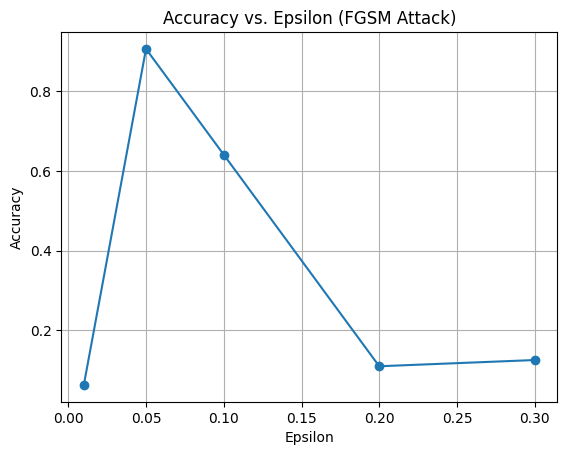

In [6]:
import matplotlib.pyplot as plt

epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
accuracies = []

for epsilon in epsilons:
    val_generator.reset()
    _, acc = evaluate_adversarial(adv_model, val_generator, epsilon)
    accuracies.append(acc)
    print(f"Epsilon: {epsilon}, Accuracy: {acc:.4f}")

# Plot
plt.plot(epsilons, accuracies, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epsilon (FGSM Attack)')
plt.grid(True)
plt.savefig('epsilon_vs_accuracy.png')
plt.show()

In [7]:
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB0

# Function to build and train a model
def build_and_train_model(base_model_class, model_name):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(10, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, verbose=1)
    
    # Evaluate
    val_generator.reset()
    clean_loss, clean_acc = model.evaluate(val_generator, verbose=0)
    fgsm_loss, fgsm_acc = evaluate_adversarial(model, val_generator, epsilon=EPSISON)
    
    print(f"\n{model_name}:")
    print(f"Clean Data - Loss: {clean_loss:.4f}, Accuracy: {clean_acc:.4f}")
    print(f"FGSM Attack (epsilon={EPSISON}) - Loss: {fgsm_loss:.4f}, Accuracy: {fgsm_acc:.4f}")
    return clean_acc, fgsm_acc

# Train and evaluate VGG16, MobileNetV2, and EfficientNetB0 (as a YOLO-like backbone)
vgg_clean, vgg_fgsm = build_and_train_model(VGG16, "VGG16")
mobilenet_clean, mobilenet_fgsm = build_and_train_model(MobileNetV2, "MobileNetV2")
efficientnet_clean, efficientnet_fgsm = build_and_train_model(EfficientNetB0, "EfficientNetB0 (YOLO-like)")

# Compare with ResNet50
print("\nResNet50 (Natural):")
print(f"Clean Accuracy: {natural_clean_acc:.4f}, FGSM Accuracy: {natural_fgsm_acc:.4f}")
print("ResNet50 (Adversarial):")
print(f"Clean Accuracy: {adv_clean_acc:.4f}, FGSM Accuracy: {adv_fgsm_acc:.4f}")

Epoch 1/20
157/157 [==============================] - 12s 64ms/step - loss: 2.2270 - accuracy: 0.2178 - val_loss: 2.1328 - val_accuracy: 0.3140
Epoch 2/20
157/157 [==============================] - 10s 61ms/step - loss: 2.0599 - accuracy: 0.3542 - val_loss: 1.9967 - val_accuracy: 0.3580
Epoch 3/20
157/157 [==============================] - 10s 61ms/step - loss: 1.9357 - accuracy: 0.3734 - val_loss: 1.8832 - val_accuracy: 0.3710
Epoch 4/20
157/157 [==============================] - 10s 61ms/step - loss: 1.8386 - accuracy: 0.4080 - val_loss: 1.8022 - val_accuracy: 0.4080
Epoch 5/20
157/157 [==============================] - 10s 61ms/step - loss: 1.7634 - accuracy: 0.4230 - val_loss: 1.7321 - val_accuracy: 0.4180
Epoch 6/20
157/157 [==============================] - 10s 61ms/step - loss: 1.7076 - accuracy: 0.4396 - val_loss: 1.6801 - val_accuracy: 0.4260
Epoch 7/20
157/157 [==============================] - 10s 61ms/step - loss: 1.6621 - accuracy: 0.4446 - val_loss: 1.6428 - val_accuracy: